<a href="https://colab.research.google.com/github/PraDhYoT2709/Load_Forecasting/blob/main/33_KVA_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📊 Forecast Results for kVA - 33
✅ MAE: 659.09
✅ MAPE (unsafe): 3.50%
✅ MAPE (safe): 3.50%
✅ RMSE: 876.07
✅ R2 Score: 0.97
✅ Accuracy (±5% band): 81.61%


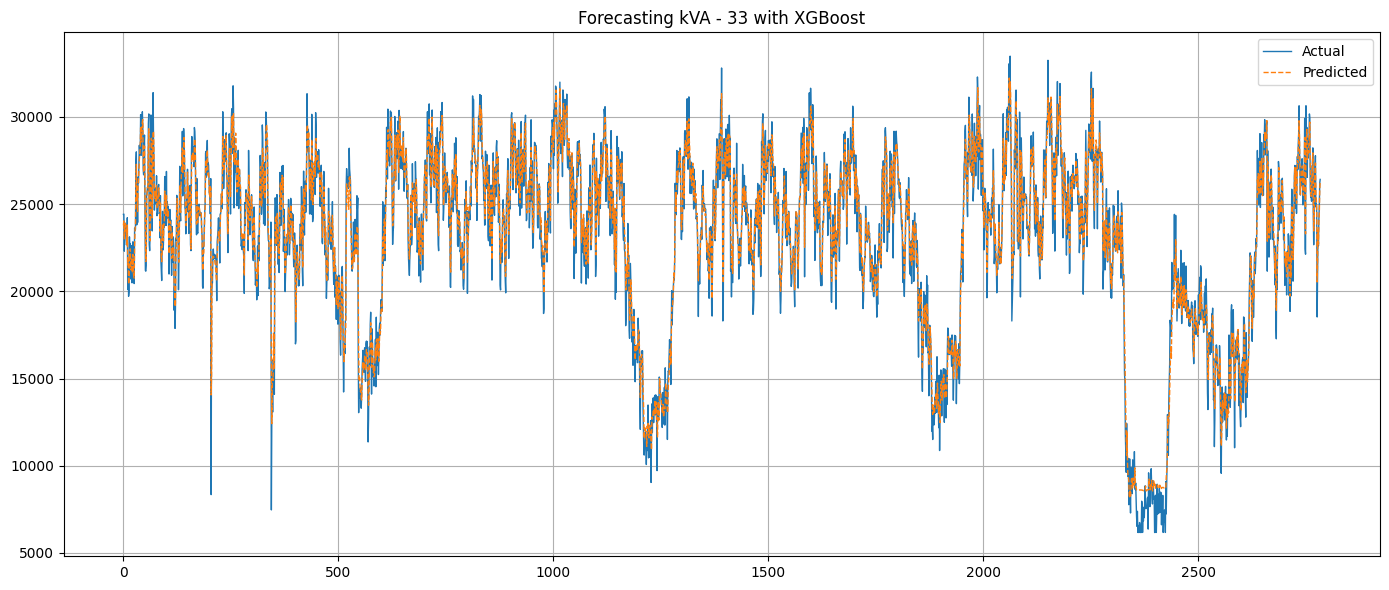

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Load dataset
df = pd.read_excel("/content/load all 3 lines.xlsx")

# Combine date and time if separate
if 'Date' in df.columns and 'Time' in df.columns:
    df['Date Time'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
else:
    df['Date Time'] = pd.to_datetime(df['Date Time'])

df.set_index('Date Time', inplace=True)

# Target column
target_column = 'kVA - 33'
df['load'] = df[target_column]

# Clip load to remove extreme outliers (optional)
load_min = df['load'].min()
load_max = df['load'].max()
lower = load_min + 0.15 * (load_max - load_min)
upper = load_min + 0.85 * (load_max - load_min)
df['load'] = df['load'].clip(lower=lower, upper=upper)

# Feature Engineering
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# Lag features
for lag in [1, 2, 4, 8, 16, 24]:
    df[f'lag_{lag}'] = df['load'].shift(lag)

# Rolling statistics
df['rolling_mean_4h'] = df['load'].rolling(window=16).mean()
df['rolling_std_4h'] = df['load'].rolling(window=16).std()

# Drop missing rows from shifting and rolling
df.dropna(inplace=True)

# Prepare X and y
X = df.drop(columns=[target_column, 'load'])
y = df['load']

# Ensure only numeric features
X = X.select_dtypes(include=[np.number])

# Split data
cutoff = pd.to_datetime("2025-02-18")
X_train = X[X.index < cutoff]
X_test = X[X.index >= cutoff]
y_train = y[y.index < cutoff]
y_test = y[y.index >= cutoff]

# Define model
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.04,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
safe_mape = np.mean(np.abs((y_test[y_test != 0] - y_pred[y_test != 0]) / y_test[y_test != 0])) * 100

# ±5% Band Accuracy
band_lower = y_test * 0.95
band_upper = y_test * 1.05
band_accuracy = ((y_pred >= band_lower) & (y_pred <= band_upper)).mean() * 100

# Print Results
print(f"📊 Forecast Results for {target_column}")
print(f"✅ MAE: {mae:.2f}")
print(f"✅ MAPE (unsafe): {mape:.2f}%")
print(f"✅ MAPE (safe): {safe_mape:.2f}%")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R2 Score: {r2:.2f}")
print(f"✅ Accuracy (±5% band): {band_accuracy:.2f}%")

# Plot Results
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual', linewidth=1)
plt.plot(y_pred, label='Predicted', linestyle='--', linewidth=1)
plt.title(f"Forecasting {target_column} with XGBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
